In [1]:
using Plots, Flux, DataFrames, CSV, ProgressMeter, Statistics

In [2]:
df  = CSV.read("data/Landslides.csv", DataFrame)
display(df)

Row,dist_roads,DEM,TWI,plan_curvature,profil_curvature,Slope,Geology,LandCover,LS
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64
1,90.1388,957.1,10.0174,0.00257542,1.56e-5,11.0455,2,41,0
2,282.843,536.1,9.21162,-0.00012923,-0.000289093,3.57188,1,21,0
3,90.1388,768.1,10.0824,0.00623542,-0.00240442,44.0343,2,41,0
4,79.0569,449.4,7.35267,0.00420136,0.00116142,11.3254,24,21,1
5,25.0,784.8,8.60168,0.00208871,-0.00271119,19.0155,1,41,1
6,25.0,991.5,13.7942,-0.00129205,0.00126791,8.28275,9,21,0
7,35.3553,569.2,8.86016,-0.00346738,0.00069258,23.9199,24,31,1
8,70.7107,1211.4,9.46106,-0.00180184,-0.00452195,21.2627,9,21,0
9,413.824,1592.5,8.28995,-0.00207019,0.00560989,38.1138,7,31,1


In [4]:
# Vectors of length 2, as columns of a matrix:
noisy = Array(df[1:500,1:6])'    # 2×1000 Matrix{Float32}
truth = Array(df[1:500,9]).==1;  #   1000-element Vector{Bool}
println( (size(noisy), size(truth)) )
noisy = Flux.normalise(noisy)

((6, 500), (

500,))


6×500 Matrix{Float64}:
 -0.320718   0.143765   -0.320718  …  -0.452765    0.301322   0.314202
  0.157565  -0.868437   -0.303039      0.558949   -0.777779   0.734905
  0.14017   -0.218315    0.169102      0.191452    1.08586   -0.617469
  0.392689  -0.101545    1.0615        0.0122482  -0.107179   0.0614598
  0.101397   0.0545073  -0.271021     -0.0713145   0.123627   0.265616
 -0.401965  -1.0548      2.47966   …   0.738306   -1.23358   -0.606456

In [6]:
model = Chain(
    Dense(6 => 25, tanh),   # activation function inside layer
    BatchNorm(25),
    Dense(25 => 2),
    softmax) 

Chain(
  Dense(6 => 25, tanh),                 # 175 parameters
  BatchNorm(25),                        # 50 parameters, plus 50
  Dense(25 => 2),                       # 52 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 277 parameters,
          # plus 2 non-trainable, 50 parameters, summarysize 1.754 KiB.

In [7]:
out1 = model( noisy );

In [8]:
pars = Flux.params(model)  # contains references to arrays in model
opt = Flux.Adam(0.05)      # will store optimiser momentum, etc.

Adam(0.05, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [9]:
# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target), batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

8-element DataLoader(::Tuple{Matrix{Float64}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=64)
  with first element:
  (6×64 Matrix{Float64}, 2×64 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [10]:
loss1(model, x, y) = Flux.crossentropy(model(x), y);
loss1(model, noisy, target)
# Define the accuracy 
accuracy(x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [11]:
# Training loop, using the whole data set 1000 times:
losses = []
accuracies = []
for epoch in 1:1000 #@showprogress 
    for (x, y) in loader
        loss, grad = Flux.withgradient(pars) do
            # Evaluate model and loss inside gradient context:
            y_hat = model(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(opt, pars, grad)
        push!(losses, loss)  # logging, outside gradient context
        accu=accuracy(noisy, target)
        push!(accuracies, accu)
    end
end

In [12]:
@show loss1(model, noisy, target)
@show accuracy(noisy, target)

loss1(model, noisy, target) = 0.03242726109548499
accuracy(noisy, target) = 0.99


0.99

In [13]:
out2 = model(noisy)  # first row is prob. of true, second row p(false)
mean((out2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!

0.99

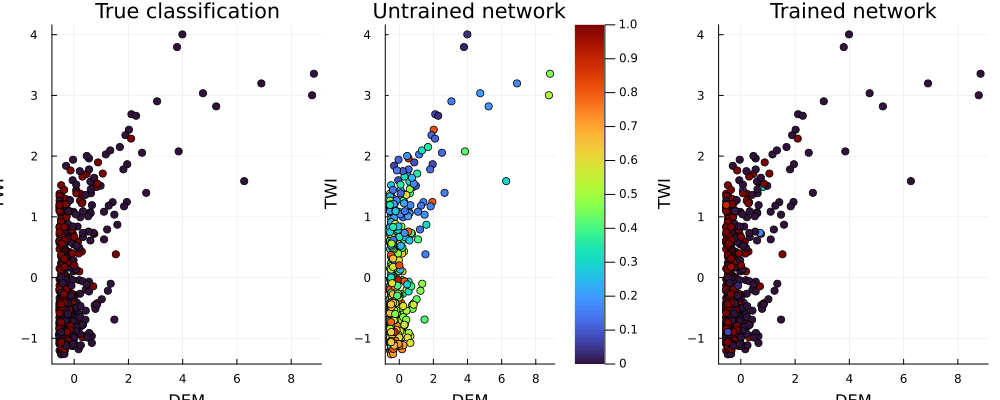

In [14]:
p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth,     title="True classification", legend=false, c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1), c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false, c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,400))

n = length(loader) = 8


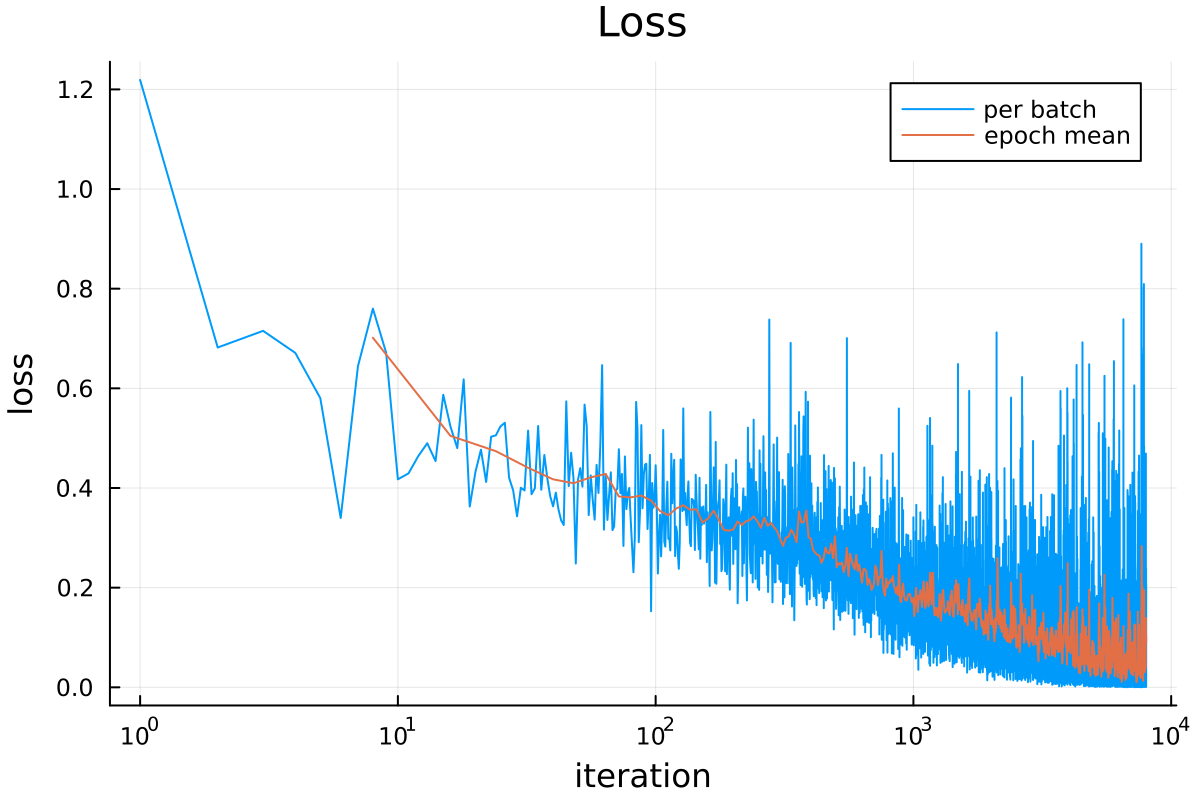

In [15]:
plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
@show n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean", title="Loss", dpi=200)

n = length(loader) = 8


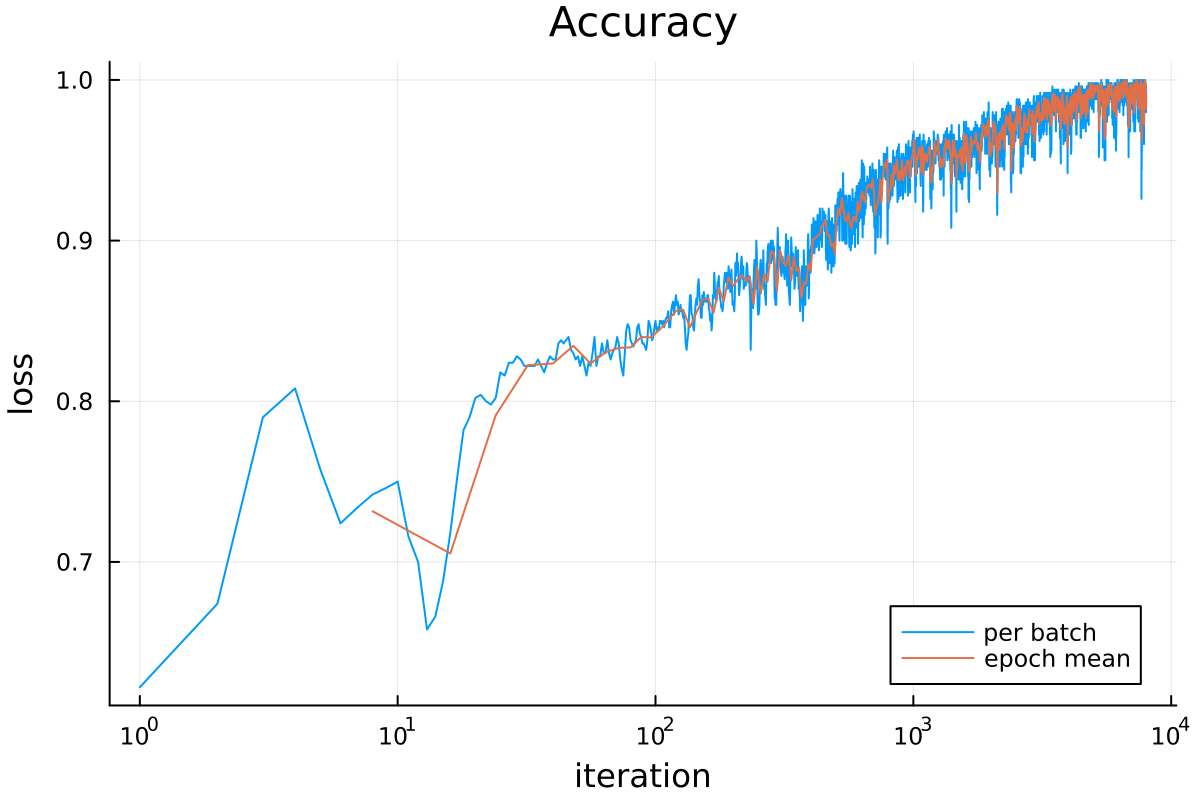

In [16]:
plot(accuracies; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
@show n = length(loader)
plot!(n:n:length(accuracies), mean.(Iterators.partition(accuracies, n)),
    label="epoch mean", title="Accuracy", dpi=200)

In [18]:
# test
noisy_t = Array(df[501:end,1:6])'    # 2×1000 Matrix{Float32}
truth_t = Array(df[501:end,9]).==1;  #   1000-element Vector{Bool}
noisy_t = Flux.normalise(noisy_t)
target_t = Flux.onehotbatch(truth_t, [true, false])                   # 2×1000 OneHotMatrix
loader_t = Flux.DataLoader((noisy_t, target_t), batchsize=64, shuffle=true);
@show accuracy(noisy_t, target_t)


accuracy(noisy_t, target_t) = 0.7543223052294558


0.7543223052294558